In [47]:
import cv2

import numpy as np
import pandas as pd
from joblib import load, dump

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import (Dense, Embedding, Reshape, Activation, 
                          SimpleRNN, LSTM, Convolution1D, 
                          MaxPooling1D, Dropout, Bidirectional)
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras import optimizers

nPoints = 18

KEYPOINTS = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16]]

POSE_PAIRS_MOD = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [8,11]]

def plotSinglePose(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((360, 640))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        
        for pair in POSE_PAIRS:
            # Checking just xcoord for valid point is enough
            valid_pt1 = (posePoint[pair[0]][0] != -1)
            valid_pt2 = (posePoint[pair[1]][0] != -1)
            if valid_pt1 and valid_pt2:
                xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()

def plotSinglePose_mod(posePoint):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 15]
        #ims = []
        #fig = plt.figure()
        
        imgArray = np.ones((360, 640))
        plt.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
        #ims.append([im])
        plt.axis('off')
        with plt.style.context('Solarize_Light2'):
            for pair in POSE_PAIRS_MOD:
                # Checking just xcoord for valid point is enough
                valid_pt1 = (posePoint[pair[0]][0] != -1)
                valid_pt2 = (posePoint[pair[1]][0] != -1)
                if valid_pt1 and valid_pt2:
                    xs = [posePoint[pair[0]][0], posePoint[pair[1]][0]]
                    ys = [posePoint[pair[0]][1], posePoint[pair[1]][1]]
                    plt.plot(xs, ys,'ko-', linewidth=2)
                
        #ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
        #                        repeat_delay=1000)
        plt.show()        

def genSalsa(seedPoses, salsaModel, steps = 8):
    seqLen = seedPoses.shape[1]
    for i in range(steps):
        y_pred = salsa_model.predict(seedPoses[:,-(seqLen):,:])
        seedPoses = np.append(seedPoses, [y_pred], axis=1)
    return seedPoses
        
def flat_to_pose(flatPose):
    pose_dim = flatPose.reshape((-1, 2))
    
    return {i:pose_dim[i].tolist() for i in range(0, len(pose_dim))}
    

pose_data_file = "../data/frames/forRNN_pose_by_daner.out"
pose_data_by_dancer = load(pose_data_file)

In [48]:
dancers = len(pose_data_by_dancer)
X = []
y = []
seqLen = 8
slide = 1

for dancer in range(dancers):
    pose_coords = pose_data_by_dancer[dancer]
    poses = len(pose_coords)
    if poses<60:
        continue #go to next dancer
    
    for i in range(0, poses - seqLen, slide):
        X.append(pose_coords[i:i+seqLen])
        y.append(pose_coords[i+seqLen])

X = np.array(X)
y = np.array(y)

In [49]:
print(X.shape)
print(y.shape)

(34944, 8, 36)
(34944, 36)


In [34]:
salsa_model = load_model("../models/threelayerLSTM_relu_36kp_8seql_60iters.h5")

In [35]:
salsa_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 36)             10512     
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 36)             10512     
_________________________________________________________________
lstm_3 (LSTM)                (None, 36)                10512     
_________________________________________________________________
dense_1 (Dense)              (None, 36)                1332      
Total params: 32,868
Trainable params: 32,868
Non-trainable params: 0
_________________________________________________________________


In [37]:
early_stopping = EarlyStopping(monitor='loss', min_delta = 0.001, patience=6, verbose=1)
#tb = TensorBoard(histogram_freq=1, write_grads=True)

kpoints = 36

# Model
#print('Build model...')
#salsa_model = Sequential()
#salsa_model.add(LSTM(kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=True))
#salsa_model.add(LSTM(kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=True))
#salsa_model.add(LSTM(kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=False))
#salsa_model.add(Dense(kpoints))
adm = optimizers.Adam(lr=0.01, decay=0.9)
salsa_model.compile(optimizer=adm, loss='mse', metrics=['mse'])
hist = salsa_model.fit(X, y, epochs=120, verbose=True)

Epoch 1/120
34944/34944 [==============================] - 21s 611us/step - loss: 3072.7939 - mean_squared_error: 3072.7939
Epoch 2/120
34944/34944 [==============================] - 19s 551us/step - loss: 3015.2681 - mean_squared_error: 3015.2681
Epoch 3/120
34944/34944 [==============================] - 20s 564us/step - loss: 3011.7492 - mean_squared_error: 3011.7492
Epoch 4/120
34944/34944 [==============================] - 20s 567us/step - loss: 3009.7605 - mean_squared_error: 3009.7605
Epoch 5/120
34944/34944 [==============================] - 20s 566us/step - loss: 3008.4657 - mean_squared_error: 3008.4657
Epoch 6/120
34944/34944 [==============================] - 20s 564us/step - loss: 3007.5463 - mean_squared_error: 3007.5463
Epoch 7/120
34944/34944 [==============================] - 20s 576us/step - loss: 3006.8372 - mean_squared_error: 3006.8372
Epoch 8/120
34944/34944 [==============================] - 20s 568us/step - loss: 3006.2308 - mean_squared_error: 3006.2308
Epoch 9/

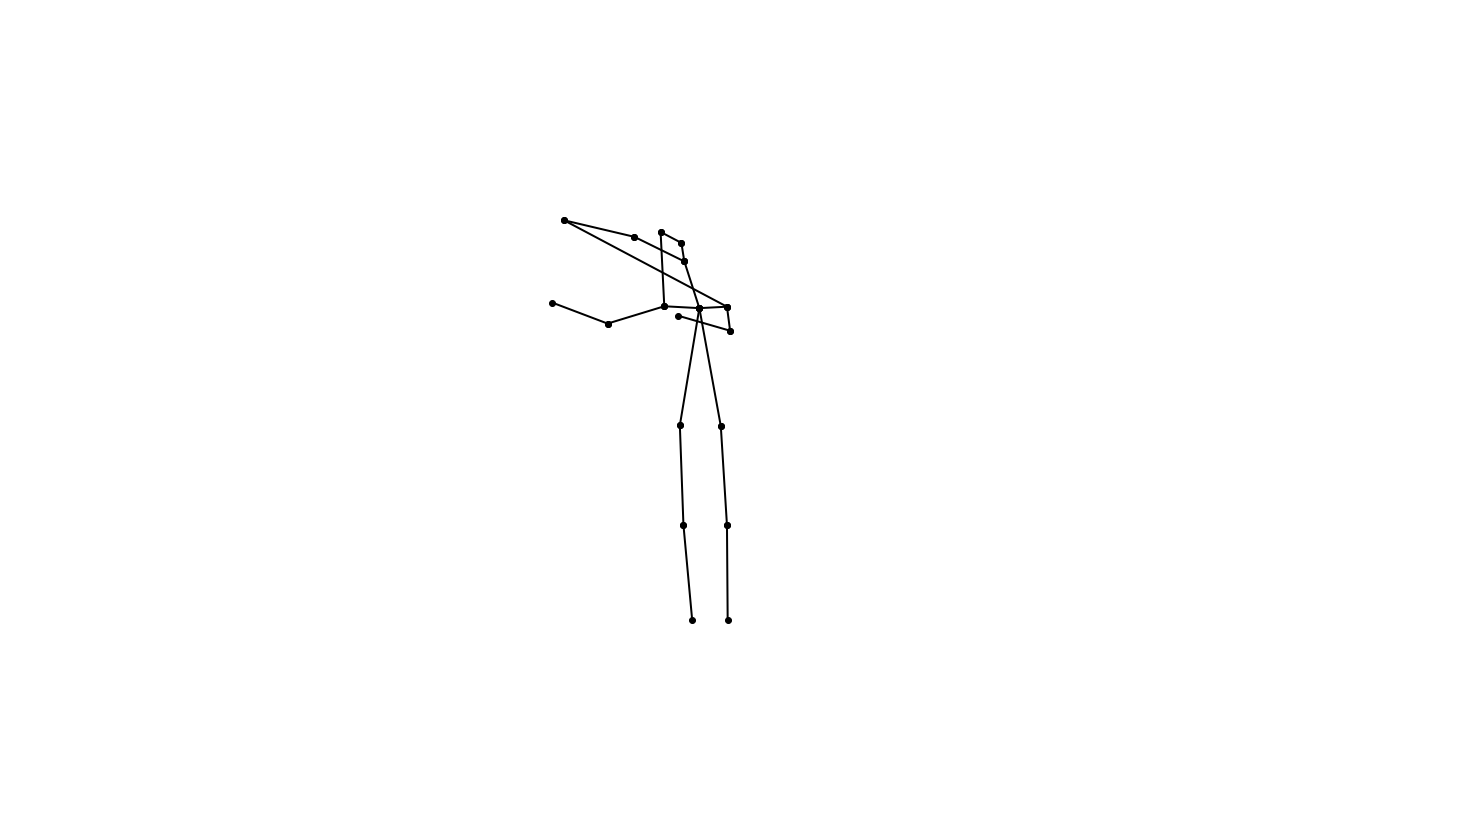

In [40]:
#from keras.models import load_model
#salsa_model = load_model("../models/threelayerLSTM.h5")
import time

d = 3#np.random.randint(31, 39)
p = np.random.randint(0, len(pose_data_by_dancer[d]))
x = np.array([pose_data_by_dancer[d][p: p+seqLen]])
gen_salsa = genSalsa(x, salsa_model, 48)
#y_test = salsa_model.predict(x)
#print(x)
plt.rcParams['figure.figsize'] = [30, 15]
plotSinglePose(flat_to_pose(gen_salsa[0,seqLen+1,:]))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


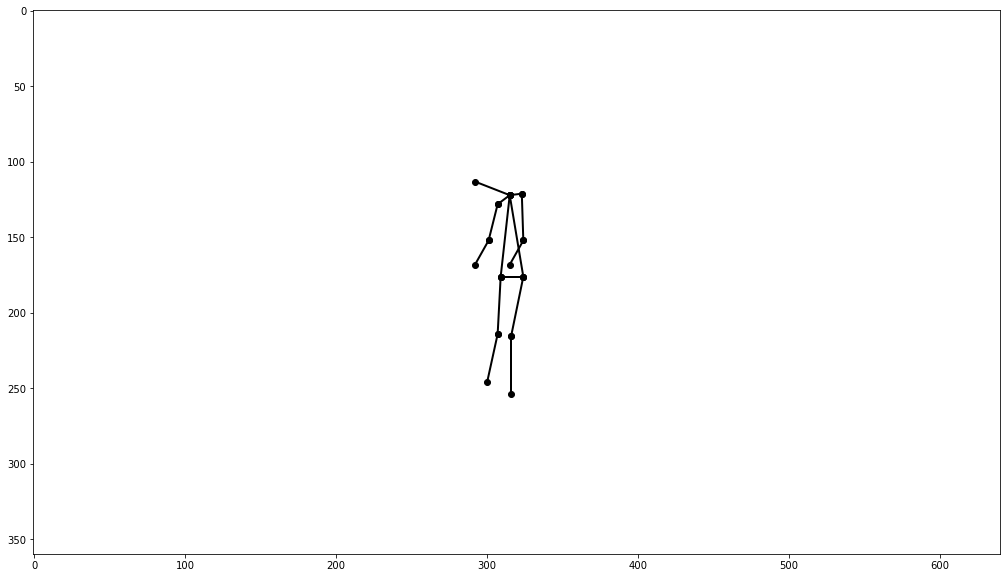

In [41]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

x_for_anim = gen_salsa

plt.rcParams['figure.figsize'] = [20, 10]                              
fig = plt.figure()
ax = plt.axes(xlim=(0, 640), ylim=(0, 360))
                              
def animate(i):
    ax.clear()
    pose = x_for_anim[0][i].reshape((-1, 2))
    #print(pose)
    imgArray = np.ones((360, 640))
    ax.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
    for pair in POSE_PAIRS_MOD:
        # Checking just xcoord for valid point is enough
        valid_pt1 = (pose[pair[0]][0] != -1)
        valid_pt2 = (pose[pair[1]][0] != -1)
        if valid_pt1 and valid_pt2:
            xs = [pose[pair[0]][0], pose[pair[1]][0]]
            ys = [pose[pair[0]][1], pose[pair[1]][1]]
            ax.plot(xs, ys,'ko-', linewidth=2)                         

anim = FuncAnimation(fig, animate, frames=56, interval=125)
anim
anim.save('redo_temp3_180iters.gif', writer='imagemagick')

In [42]:
salsa_model.save("../models/threelayerLSTM_relu_36kp_8seql_180iters.h5")

In [51]:
# Model
print('Build model...')
stest = Sequential()
stest.add(LSTM(6*kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=True))
#salsa_model.add(Dropout(drop_prob))
stest.add(LSTM(3*kpoints, activation='relu', return_sequences=False))
#salsa_model.add(Dropout(drop_prob))
stest.add(Dense(kpoints))
adm = optimizers.Adam(lr=0.01, decay=0.8)
stest.compile(optimizer=adm, loss='mse', metrics=['mse'])
stest.summary()
hist = stest.fit(X, y, epochs=12, verbose=True)

Build model...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 8, 216)            218592    
_________________________________________________________________
lstm_17 (LSTM)               (None, 108)               140400    
_________________________________________________________________
dense_8 (Dense)              (None, 36)                3924      
Total params: 362,916
Trainable params: 362,916
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
34944/34944 [==============================] - 23s 650us/step - loss: 7975.0939 - mean_squared_error: 7975.0939
Epoch 2/12
34944/34944 [==============================] - 20s 578us/step - loss: 5657.3674 - mean_squared_error: 5657.3674
Epoch 3/12
34944/34944 [==============================] - 21s 589us/step - loss: 5489.6334 - mean_squared_error: 5489

In [86]:
hist = stest.fit(X, y, epochs=12, verbose=True)

Epoch 1/12
34944/34944 [==============================] - 20s 566us/step - loss: 5071.3098 - mean_squared_error: 5071.3098
Epoch 2/12
34944/34944 [==============================] - 22s 616us/step - loss: 5051.8889 - mean_squared_error: 5051.8889
Epoch 3/12
34944/34944 [==============================] - 22s 639us/step - loss: 5039.0315 - mean_squared_error: 5039.0315
Epoch 4/12
34944/34944 [==============================] - 22s 628us/step - loss: 5025.5939 - mean_squared_error: 5025.5939
Epoch 5/12
34944/34944 [==============================] - 22s 640us/step - loss: 5011.9651 - mean_squared_error: 5011.9651
Epoch 6/12
34944/34944 [==============================] - 22s 636us/step - loss: 4999.5472 - mean_squared_error: 4999.5472
Epoch 7/12
34944/34944 [==============================] - 23s 653us/step - loss: 4987.9827 - mean_squared_error: 4987.9827
Epoch 8/12
34944/34944 [==============================] - 24s 688us/step - loss: 4977.0759 - mean_squared_error: 4977.0759
Epoch 9/12
34944

In [107]:
hist = stest.fit(X, y, epochs=12, verbose=True)

Epoch 1/12
34944/34944 [==============================] - 19s 549us/step - loss: 4814.2016 - mean_squared_error: 4814.2016
Epoch 2/12
34944/34944 [==============================] - 20s 577us/step - loss: 4810.6672 - mean_squared_error: 4810.6672
Epoch 3/12
34944/34944 [==============================] - 20s 564us/step - loss: 4807.7466 - mean_squared_error: 4807.7466
Epoch 4/12
34944/34944 [==============================] - 20s 573us/step - loss: 4804.8454 - mean_squared_error: 4804.8454
Epoch 5/12
34944/34944 [==============================] - 23s 654us/step - loss: 4801.6766 - mean_squared_error: 4801.6766
Epoch 6/12
34944/34944 [==============================] - 22s 630us/step - loss: 4799.0301 - mean_squared_error: 4799.0301
Epoch 7/12
34944/34944 [==============================] - 22s 616us/step - loss: 4796.4310 - mean_squared_error: 4796.4310
Epoch 8/12
34944/34944 [==============================] - 23s 667us/step - loss: 4793.6767 - mean_squared_error: 4793.6767
Epoch 9/12
34944

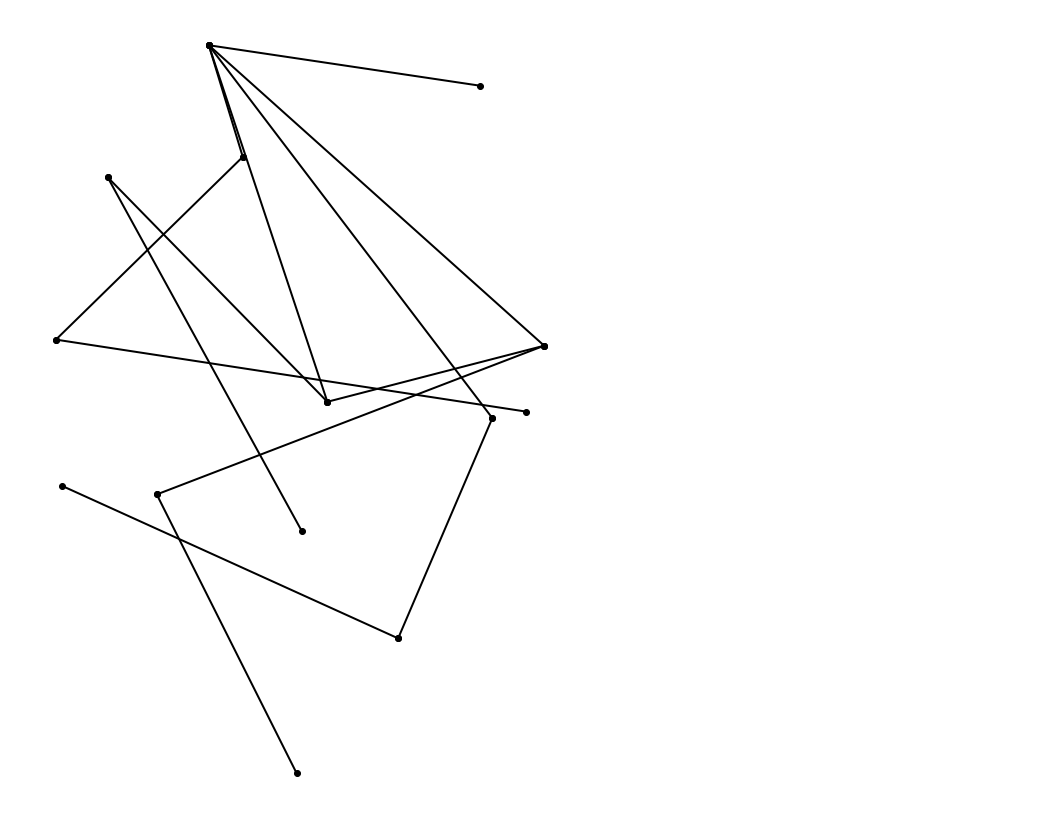

In [109]:
#from keras.models import load_model
#salsa_model = load_model("../models/threelayerLSTM.h5")
import time

d = 3#np.random.randint(1, 70)
p = np.random.randint(0, len(pose_data_by_dancer[d]))
x = np.array([pose_data_by_dancer[d][p: p+seqLen]])
gen_salsa = genSalsa(x, stest, 48)
#y_test = salsa_model.predict(x)
#print(x)
plt.rcParams['figure.figsize'] = [30, 15]
plotSinglePose_mod(flat_to_pose(gen_salsa[0,seqLen+1,:]))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


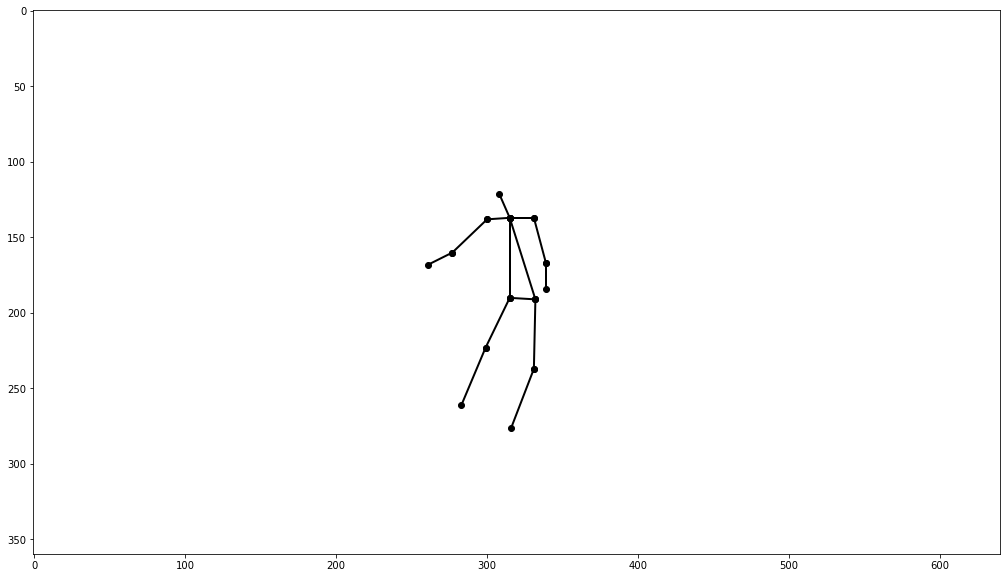

In [110]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

x_for_anim = gen_salsa

plt.rcParams['figure.figsize'] = [20, 10]                              
fig = plt.figure()
ax = plt.axes(xlim=(0, 640), ylim=(0, 360))
                              
def animate(i):
    ax.clear()
    pose = x_for_anim[0][i].reshape((-1, 2))
    #print(pose)
    imgArray = np.ones((360, 640))
    ax.imshow(imgArray, cmap=plt.cm.Greys, interpolation = 'nearest')
    for pair in POSE_PAIRS_MOD:
        # Checking just xcoord for valid point is enough
        valid_pt1 = (pose[pair[0]][0] != -1)
        valid_pt2 = (pose[pair[1]][0] != -1)
        if valid_pt1 and valid_pt2:
            xs = [pose[pair[0]][0], pose[pair[1]][0]]
            ys = [pose[pair[0]][1], pose[pair[1]][1]]
            ax.plot(xs, ys,'ko-', linewidth=2)                         

anim = FuncAnimation(fig, animate, frames=56, interval=125)
anim
anim.save('../preds/TapperHidden_12iters_a.gif', writer='imagemagick')

In [117]:
# Model
from keras.layers import TimeDistributed
print('Build model...')
stest1 = Sequential()
stest1.add(LSTM(12*kpoints, activation='relu', input_shape=(seqLen, kpoints), return_sequences=True))
#salsa_model.add(Dropout(drop_prob))
stest1.add(LSTM(12*kpoints, activation='relu', return_sequences=True))
#salsa_model.add(Dropout(drop_prob))
stest1.add(TimeDistributed(Dense(kpoints)))
adm1 = optimizers.Adam(lr=0.01, decay=0.8)
stest1.compile(optimizer=adm1, loss='mse', metrics=['mse'])
stest1.summary()

Build model...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 8, 432)            810432    
_________________________________________________________________
lstm_29 (LSTM)               (None, 8, 432)            1494720   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 8, 36)             15588     
Total params: 2,320,740
Trainable params: 2,320,740
Non-trainable params: 0
_________________________________________________________________
